Analysis of the models obtain previously

In [2]:
import sys
sys.path.append('../')
from utils import *

In [3]:
labs = pd.read_csv('data/labs_1_day.csv', index_col = [0, 1], header = [0, 1])
outcomes = pd.read_csv('data/outcomes_1_day.csv', index_col = 0)
outcomes['Death'] = outcomes.Death < 8

In [4]:
ethnicity = outcomes.ETHNICITY.str.contains('BLACK').replace({True: 'Black', False: 'Non Black'}) 
ethnicity_unique = ['Black', 'Non Black']

gender = (outcomes.GENDER == 'M').replace({True: 'Male', False: 'Female'})
gender_unique = ['Female', 'Male']

insurance = (outcomes.INSURANCE == 'Private').replace({True: 'Private', False: 'Public'})
insurance_unique = ['Public', 'Private'] 

In [5]:
pd.concat([ethnicity == "Black", gender == "Female", insurance == "Public"], 1).corr()

/tmp/ipykernel_22486/286648176.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  pd.concat([ethnicity == "Black", gender == "Female", insurance == "Public"], 1).corr()


,ETHNICITY,GENDER,INSURANCE
ETHNICITY,1.000000,0.063715,0.043458
GENDER,0.063715,1.000000,0.086312
INSURANCE,0.043458,0.086312,1.000000


In [6]:
(ethnicity + ' + ' + gender + ' + ' + insurance).value_counts()

Non Black + Male + Public       12084
Non Black + Female + Public     10026
Non Black + Male + Private       7235
Non Black + Female + Private     4170
Black + Female + Public          1159
Black + Male + Public             890
Black + Male + Private            383
Black + Female + Private          349
dtype: int64

In [7]:
results = 'results/'

# Open results

In [56]:
import os

In [57]:
names = {
    file: file[file.rindex('classification')+14:file.rindex('.csv')]
    for file in os.listdir('results') if '.csv' in file
}

In [58]:
predictions = {}

for file in names:
    predictions[names[file]] = pd.read_csv(results + file, index_col=0)
    print(file, ' -> ', names[file])

predictions = {name: predictions[name] for name in ['Group MICE Missing', 'Group MICE', 'MICE', 'Median'][::-1]}

classificationGroup MICE Missing.csv  ->  Group MICE Missing
classificationMedian.csv  ->  Median
classificationMICE.csv  ->  MICE
classificationGroup MICE.csv  ->  Group MICE


# Performances

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss

Differencesin observed labels between training and testing 

### All metrics

Evaluate all metrics on datasets

In [60]:
def evaluate(y_true, groups, groups_unique, y_pred, iterations = 100, p = 0.3):
    """
        Compute boostrapped performances
    """
    fprs, tprs, rocs, brs, screened, screened_fpr, screened_fnr = {b: [] for b in groups_unique}, {b: [] for b in groups_unique}, \
        {b: [] for b in groups_unique}, {b: [] for b in groups_unique}, {b: [] for b in groups_unique}, {b: [] for b in groups_unique}, {b: [] for b in groups_unique}

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fpr_sort = np.argsort(fpr)
    tpr_sort = np.argsort(tpr)
    threshold_fpr = np.interp(0.9, tpr[tpr_sort], thresholds[tpr_sort])
    threshold_tpr = np.interp(0.1, fpr[fpr_sort], thresholds[fpr_sort])

    # Threshold screening
    threshold_top = pd.Series(y_pred).nlargest(int(len(y_pred) * p), keep = 'all').min()

    for group in groups_unique:
        if group == 'Overall':
            y_pred_group = y_pred
            y_true_group = y_true
        else:
            y_pred_group = y_pred[groups == group]
            y_true_group = y_true[groups == group]

        for i in range(iterations):
            bootstrap = np.random.choice(np.arange(len(y_pred_group)), size = len(y_pred_group), replace = True) 
            y_pred_iteration = y_pred_group[bootstrap]
            y_true_iteration = y_true_group[bootstrap]

            # Standard metrics on the boostrapped sample
            brs[group].append(brier_score_loss(y_true_iteration, y_pred_iteration))
            fpr, tpr, thresholds = roc_curve(y_true_iteration, y_pred_iteration)
            thres_order = np.argsort(thresholds)
            fprs[group].append(np.interp(threshold_fpr, thresholds[thres_order], fpr[thres_order]))
            tprs[group].append(np.interp(threshold_tpr, thresholds[thres_order], tpr[thres_order]))
            rocs[group].append(roc_auc_score(y_true_iteration, y_pred_iteration))

            # Percentage screened-out in bottom 30 %
            selected = y_pred_iteration >= threshold_top
            screened[group].append(np.mean(selected)) # Percentage of patients in this group that are prioritized
            screened_fnr[group].append((y_true_iteration[~selected]).sum() / y_true_iteration.sum()) # Wrongly not prioritized
            screened_fpr[group].append((1 - y_true_iteration[selected]).sum() / (1 - y_true_iteration).sum()) # Wrongly prioritized

    result = {}
    if len(groups_unique) == 2:
        difference = 'Difference {} - {}'.format(groups_unique[0], groups_unique[1])
        result.update({
            (difference, "Brier Score", 'Mean'): np.mean(np.array(brs[groups_unique[0]]) - np.array(brs[groups_unique[1]])),
            (difference, "Brier Score", 'Std'): np.std(np.array(brs[groups_unique[0]]) - np.array(brs[groups_unique[1]])),
            (difference, "AUC ROC", 'Mean'): np.mean(np.array(rocs[groups_unique[0]]) - np.array(rocs[groups_unique[1]])),
            (difference, "AUC ROC", 'Std'): np.std(np.array(rocs[groups_unique[0]]) - np.array(rocs[groups_unique[1]])),

            (difference, "FPR @ 90% TPR", 'Mean'): np.mean(np.array(fprs[groups_unique[0]]) - np.array(fprs[groups_unique[1]])),
            (difference, "FPR @ 90% TPR", 'Std'): np.std(np.array(fprs[groups_unique[0]]) - np.array(fprs[groups_unique[1]])),
            (difference, "TPR @ 10% FPR", 'Mean'): np.mean(np.array(tprs[groups_unique[0]]) - np.array(tprs[groups_unique[1]])),
            (difference, "TPR @ 10% FPR", 'Std'): np.std(np.array(tprs[groups_unique[0]]) - np.array(tprs[groups_unique[1]])),

            (difference, "Prioritized", 'Mean'): np.mean(np.array(screened[groups_unique[0]]) - np.array(screened[groups_unique[1]])),
            (difference, "Prioritized", 'Std'): np.std(np.array(screened[groups_unique[0]]) - np.array(screened[groups_unique[1]])),
            (difference, "Wrongly prioritized (FPR)", 'Mean'): np.mean(np.array(screened_fpr[groups_unique[0]]) - np.array(screened_fpr[groups_unique[1]])),
            (difference, "Wrongly prioritized (FPR)", 'Std'): np.std(np.array(screened_fpr[groups_unique[0]]) - np.array(screened_fpr[groups_unique[1]])),
            (difference, "Wrongly not prioritized (FNR)", 'Mean'): np.mean(np.array(screened_fnr[groups_unique[0]]) - np.array(screened_fnr[groups_unique[1]])),
            (difference, "Wrongly not prioritized (FNR)", 'Std'): np.std(np.array(screened_fnr[groups_unique[0]]) - np.array(screened_fnr[groups_unique[1]])),
        })
    for group in groups_unique:
        result.update({
            (group, "Brier Score", 'Mean'): np.mean(brs[group]),
            (group, "Brier Score", 'Std'): np.std(brs[group]),
            (group, "AUC ROC", 'Mean'): np.mean(rocs[group]),
            (group, "AUC ROC", 'Std'): np.std(rocs[group]),

            (group, "FPR @ 90% TPR", 'Mean'): np.mean(fprs[group]),
            (group, "FPR @ 90% TPR", 'Std'): np.std(fprs[group]),
            (group, "TPR @ 10% FPR", 'Mean'): np.mean(tprs[group]),
            (group, "TPR @ 10% FPR", 'Std'): np.std(tprs[group]),

            (group, "Prioritized", 'Mean'): np.mean(screened[group]),
            (group, "Prioritized", 'Std'): np.std(screened[group]),
            (group, "Wrongly prioritized (FPR)", 'Mean'): np.mean(screened_fpr[group]),
            (group, "Wrongly prioritized (FPR)", 'Std'): np.std(screened_fpr[group]),
            (group, "Wrongly not prioritized (FNR)", 'Mean'): np.mean(screened_fnr[group]),
            (group, "Wrongly not prioritized (FNR)", 'Std'): np.std(screened_fnr[group]),
        })
    return pd.Series(result)

In [61]:
# Compute and display performances per group of model
performances = {}
for groups, groups_unique, group_name in [(gender, gender_unique, 'Gender'), (ethnicity, ethnicity_unique, 'Ethnicity'), (insurance, insurance_unique, 'Insurance'), (outcomes, ['Overall'], 'Overall')]:
    print('-' * 42)
    print('Computing for group: ', group_name)
    perf_group = {}
    for m in predictions:
        print('\t- ', m)
        perf_group[m] = {}

        np.random.seed(42)
        preds = predictions[m]

        test = preds.Use != 'Train' # Use the data that will be used for both   
        test = test[test].index
        
        perf_group[m] = evaluate(outcomes.Death.loc[test].values, groups.loc[test].values, groups_unique, preds.loc[test]['Mean'].values)
    performances[group_name] = pd.concat(perf_group, axis = 1).T

------------------------------------------
Computing for group:  Gender
	-  Median
	-  MICE
	-  Group MICE
	-  Group MICE Missing
------------------------------------------
Computing for group:  Ethnicity
	-  Median
	-  MICE
	-  Group MICE
	-  Group MICE Missing
------------------------------------------
Computing for group:  Insurance
	-  Median
	-  MICE
	-  Group MICE
	-  Group MICE Missing
------------------------------------------
Computing for group:  Overall
	-  Median
	-  MICE
	-  Group MICE
	-  Group MICE Missing


### Display performance

In [79]:
metric = "AUC ROC" #'Prioritized', 'AUC ROC', 'Wrongly not prioritized (FNR)'

In [80]:
for groups, groups_unique, group_name in [(gender, gender_unique, 'Gender'), (ethnicity, ethnicity_unique, 'Ethnicity'), (insurance, insurance_unique, 'Insurance'), (outcomes, ['Overall'], 'Overall')]:
    perf_group = performances[group_name][groups_unique]
    perf_group = perf_group.loc[:, perf_group.columns.get_level_values(1) == metric].droplevel(1, 1)
    perf_group = pd.DataFrame.from_dict({model: ["{:.3f} ({:.3f})".format(perf_group.loc[model].loc[i].Mean, perf_group.loc[model].loc[i].Std) for i in perf_group.loc[model].index.get_level_values(0).unique()] for model in perf_group.index}, columns = perf_group.columns.get_level_values(0).unique(), orient = 'index')
    print(perf_group.T.to_latex())

\begin{tabular}{lllll}
\toprule
{} &         Median &           MICE &     Group MICE & Group MICE Missing \\
\midrule
Female &  0.735 (0.016) &  0.733 (0.018) &  0.730 (0.018) &      0.769 (0.014) \\
Male   &  0.757 (0.016) &  0.748 (0.014) &  0.744 (0.014) &      0.796 (0.013) \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
{} &         Median &           MICE &     Group MICE & Group MICE Missing \\
\midrule
Black     &  0.805 (0.030) &  0.781 (0.036) &  0.765 (0.037) &      0.814 (0.029) \\
Non Black &  0.744 (0.010) &  0.740 (0.010) &  0.738 (0.010) &      0.783 (0.010) \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
{} &         Median &           MICE &     Group MICE & Group MICE Missing \\
\midrule
Public  &  0.739 (0.011) &  0.726 (0.012) &  0.722 (0.013) &      0.767 (0.011) \\
Private &  0.751 (0.021) &  0.771 (0.018) &  0.759 (0.021) &      0.821 (0.017) \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
{} &         Median &         

#### Difference in FNR

In [72]:
comparison = {}
for model in performances['Overall'].index:
    comparison[model] = pd.concat({
        'Insurance': performances['Insurance'].loc[model]['Difference Public - Private'][metric],
        'Gender': performances['Gender'].loc[model]['Difference Female - Male'][metric],
        'Ethnicty': performances['Ethnicity'].loc[model]['Difference Black - Non Black'][metric],
    }, axis = 1).T

In [73]:
metrics_short = {
    "Brier Score": "Brier",
    "AUC ROC": "AUC",
    "FPR @ 90% TPR": "FPR",
    "TPR @ 10% FPR": "TPR",
    "Prioritized": "Prioritised",
    "Wrongly prioritized (FPR)": "FPR",
    "Wrongly not prioritized (FNR)": "FNR"
}

In [74]:
comparison = pd.concat(comparison, axis = 1).swaplevel(0, axis = 1)#{model: comparison[model] for model in ['Median', 'LOCF', 'LOCF Count']}, axis = 1).swaplevel(0, axis = 1)

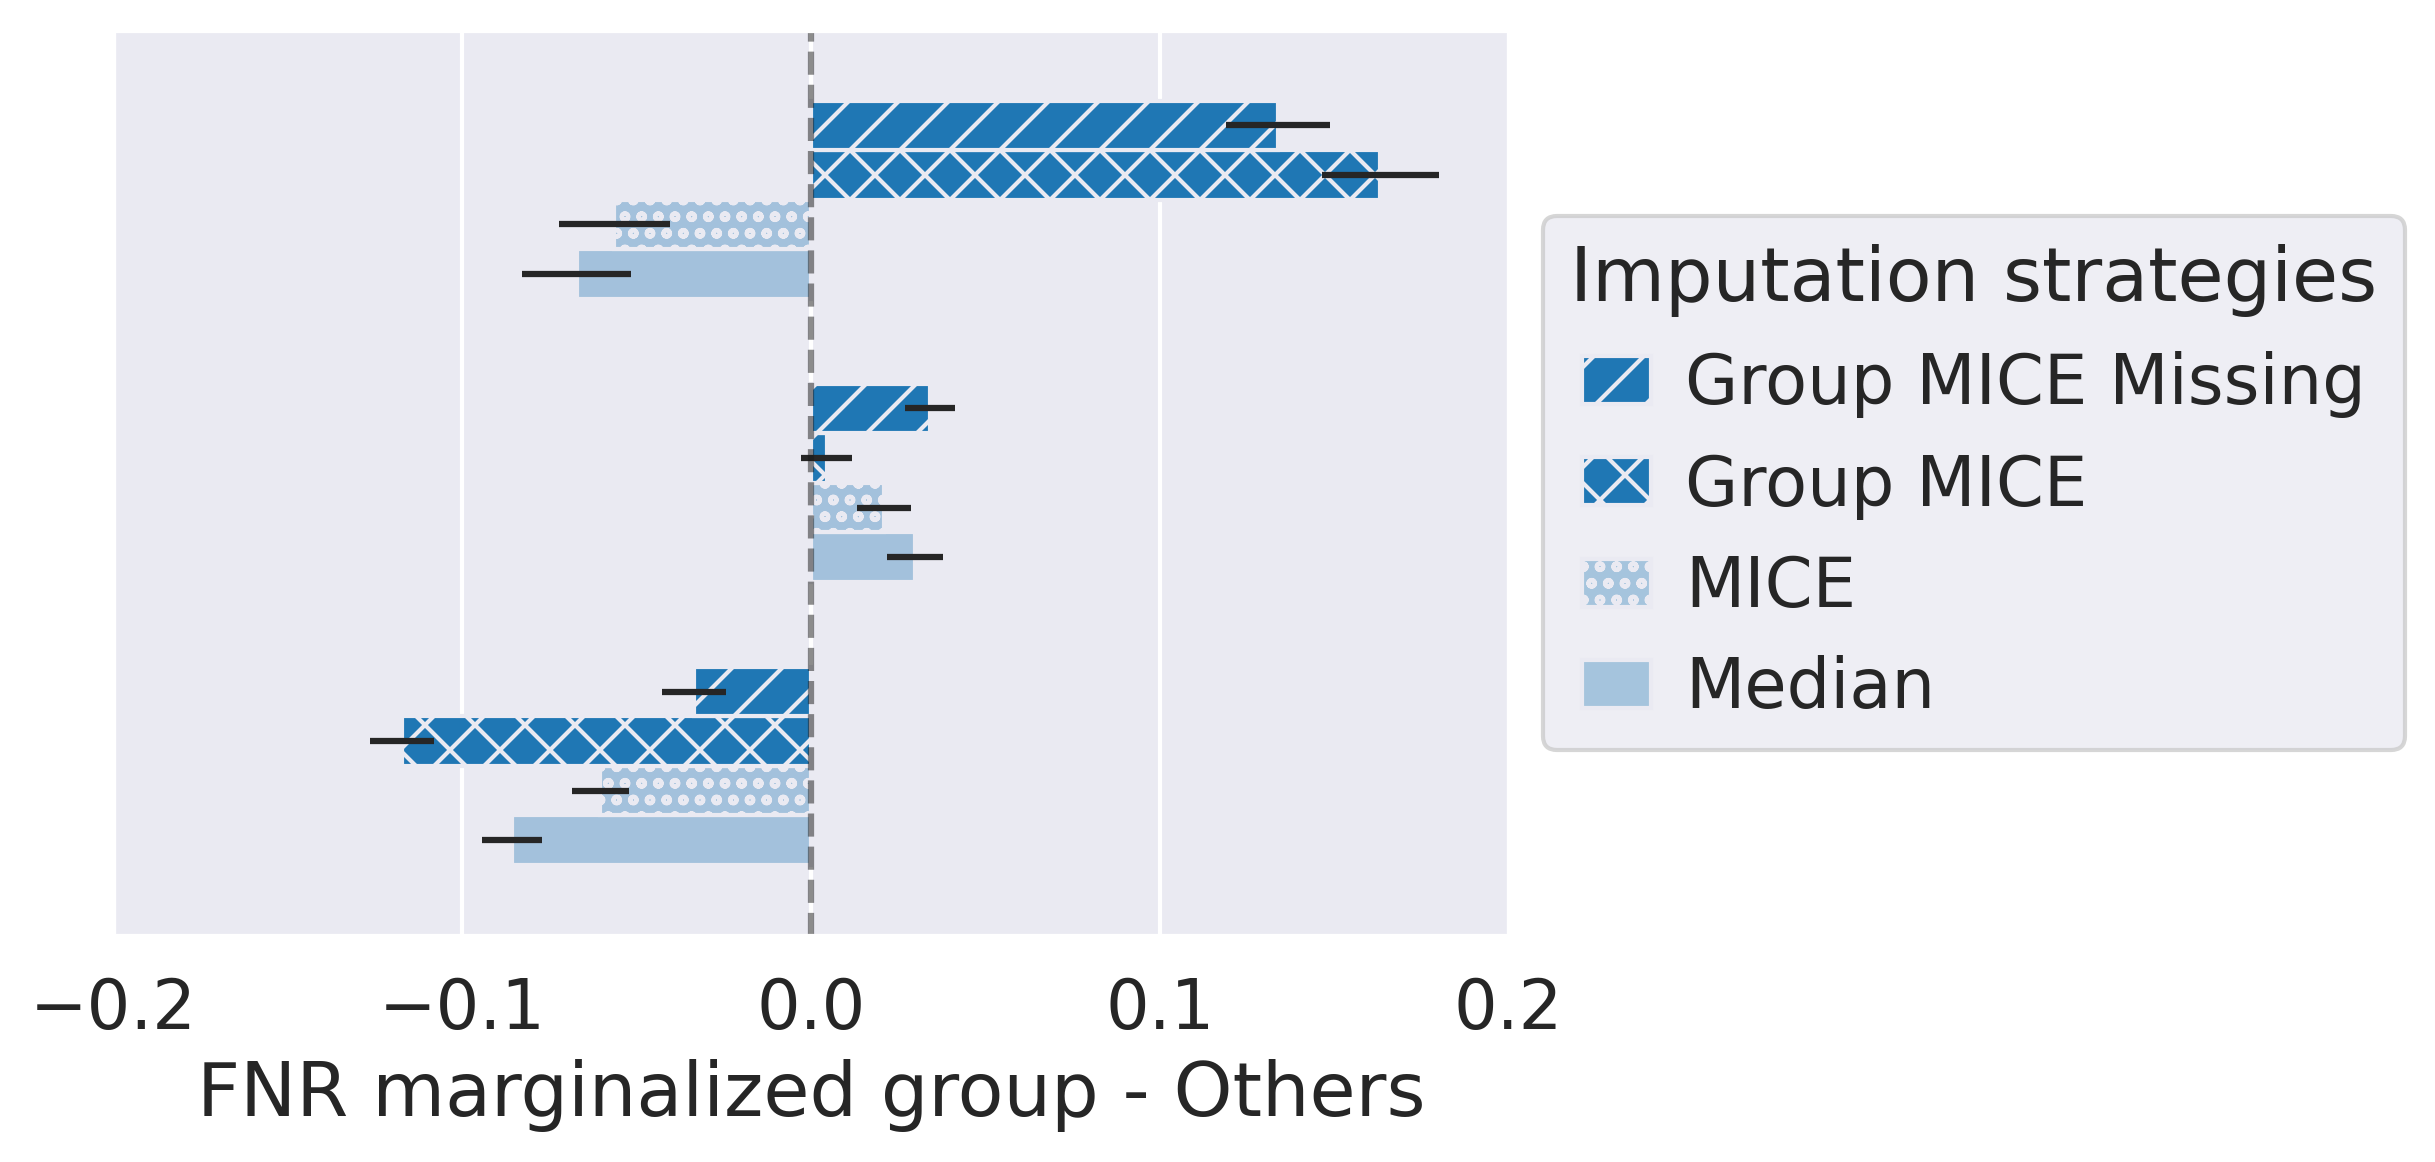

In [78]:
ax = comparison.Mean.plot.barh(xerr = 1.96 * comparison.Std / np.sqrt(100), width = 0.7, legend = 'FNR' in metric)
hatches = ['', 'ooo', 'xx', '//', '||', '***', '++']
for i, thisbar in enumerate(ax.patches):
    c = list(plt_colors.to_rgba('tab:blue'))
    c[3] = 0.35 if i // len(comparison) < 2 else 1
    thisbar.set(edgecolor = '#eaeaf2', facecolor = c, linewidth = 1, hatch = hatches[i // len(comparison)])

if 'FNR' in metric:
    patches = [ax.patches[i * len(comparison)] for i in range(len(comparison.Mean.columns))][::-1]
    labels = comparison.Mean.columns.tolist()[::-1]
    ax.legend(patches, labels, loc='center left', bbox_to_anchor=(1, 0.5),
        title = 'Imputation strategies', handletextpad = 0.5, handlelength = 1.0, columnspacing = -0.5,)
    plt.yticks([])
plt.xlim(-0.20, 0.20)
plt.axvline(0, ls = '--', alpha = 0.5, c = 'k')
plt.xlabel('{} marginalized group - Others'.format(metrics_short[metric], metrics_short[metric]))
plt.show()